In [1]:
import pyreadr as py
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from tensorflow.python.keras.callbacks import TensorBoard
import tensorflow as tf
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix,classification_report
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler,Normalizer
from tensorflow import keras
import keras_tuner as kt
import tensorflow as tf
import os
from sklearn.preprocessing import OneHotEncoder

2024-04-22 19:58:52.155693: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-22 19:58:52.222758: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 19:58:52.817094: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def plot_confusion_matrix(test_y, predict_y):
    # Convertir las probabilidades predichas en clases
    print(predict_y.shape)
    print(test_y.shape)
    #if len(predict_y.shape) == 1:
    #    predict_y_classes = predict_y.reshape(-1, 1)
    #else:
    #    predict_y_classes = np.argmax(predict_y, axis=1)
    
    # Calcular la matriz de confusión
    C = confusion_matrix(test_y, predict_y_classes)
    
    # Calcular la precisión y recall
    A = (((C.T) / (C.sum(axis=1))).T)
    B = (C / C.sum(axis=0))
    
    labels = [0,1,2,4,5,6,7,8,10,11,12,13,14,16,17,18,19,20]
    cmap = sns.light_palette("green")
    
    # Representar la matriz de confusión en formato de heatmap
    print("-" * 50, "Confusion matrix", "-" * 50)
    plt.figure(figsize=(20,20))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # Representar la matriz de precisión en formato de heatmap
    print("-" * 50, "Precision matrix", "-" * 50)
    plt.figure(figsize=(20,20))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # Representar la matriz de recall en formato de heatmap
    print("-" * 50, "Recall matrix", "-" * 50)
    plt.figure(figsize=(20,20))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))


In [3]:
#Read data
train = pd.read_csv('train.csv')
cv = pd.read_csv("cv.csv")
test = pd.read_csv("test.csv")

In [4]:
print("Shape of the sampled train data:", train.shape)
print("Shape of the sampled test data:", test.shape)
print("Shape of the sampled CV data:", cv.shape)
print(train)

Shape of the sampled train data: (270400, 56)
Shape of the sampled test data: (104000, 56)
Shape of the sampled CV data: (106400, 56)
        Unnamed: 0  faultNumber  simulationRun  sample  xmeas_1  xmeas_2  \
0                0          0.0            1.0       1  0.25038   3674.0   
1                1          0.0            1.0       2  0.25109   3659.4   
2                2          0.0            1.0       3  0.25038   3660.3   
3                3          0.0            1.0       4  0.24977   3661.3   
4                4          0.0            1.0       5  0.29405   3679.0   
...            ...          ...            ...     ...      ...      ...   
270395      239995         20.0           24.0     496  0.28437   3645.3   
270396      239996         20.0           24.0     497  0.27925   3687.0   
270397      239997         20.0           24.0     498  0.27898   3671.8   
270398      239998         20.0           24.0     499  0.26937   3691.9   
270399      239999         20.

In [5]:
# Removing faults 3,9 and 15 
tr = train.drop(train[(train.faultNumber == 3) | (train.faultNumber == 9) | (train.faultNumber == 15)].index).reset_index()
ts = test.drop(test[(test.faultNumber == 3) | (test.faultNumber == 9) | (test.faultNumber == 15)].index).reset_index()
cv_ = cv.drop(cv[(cv.faultNumber == 3) | (cv.faultNumber == 9) | (cv.faultNumber == 15)].index).reset_index()


In [6]:
print(train)
# Resizing the train, test and cv data.
x_train = np.resize(tr,(183200,52,1))
x_test = np.resize(ts,(89000,52,1))
x_cv = np.resize(cv_,(93440,52,1))

        Unnamed: 0  faultNumber  simulationRun  sample  xmeas_1  xmeas_2  \
0                0          0.0            1.0       1  0.25038   3674.0   
1                1          0.0            1.0       2  0.25109   3659.4   
2                2          0.0            1.0       3  0.25038   3660.3   
3                3          0.0            1.0       4  0.24977   3661.3   
4                4          0.0            1.0       5  0.29405   3679.0   
...            ...          ...            ...     ...      ...      ...   
270395      239995         20.0           24.0     496  0.28437   3645.3   
270396      239996         20.0           24.0     497  0.27925   3687.0   
270397      239997         20.0           24.0     498  0.27898   3671.8   
270398      239998         20.0           24.0     499  0.26937   3691.9   
270399      239999         20.0           24.0     500  0.26889   3680.8   

        xmeas_3  xmeas_4  xmeas_5  xmeas_6  ...   xmv_2   xmv_3   xmv_4  \
0        452

In [7]:
x_train.shape

(183200, 52, 1)

In [8]:
#converting the class labels to categorical values and removing unnecessary features from train, test and cv data.
y_train = tr['faultNumber']
y_test = ts['faultNumber']
y_cv = cv_['faultNumber']


encoder = OneHotEncoder()

# Ajustar y transformar los datos de salida
y_train_encoded = encoder.fit_transform(np.array(y_train).reshape(-1, 1))
y_test_encoded = encoder.fit_transform(np.array(y_test).reshape(-1, 1))
y_cv_encoded = encoder.fit_transform(np.array(y_cv).reshape(-1, 1))




In [9]:
tr.drop(['faultNumber','Unnamed: 0','simulationRun','sample','index'],axis=1,inplace=True)
ts.drop(['faultNumber','Unnamed: 0','simulationRun','sample','index'],axis =1,inplace=True)
cv_.drop(['faultNumber','Unnamed: 0','simulationRun','sample','index'],axis =1,inplace=True)
standard_scalar = StandardScaler()
train_norm = standard_scalar.fit_transform(tr)
test_norm = standard_scalar.transform(ts)
cv_norm = standard_scalar.transform(cv_)

In [10]:
tr

,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,74.863,120.41,0.33818,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,75.000,120.41,0.33620,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,74.771,120.42,0.33563,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,75.224,120.39,0.33553,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,75.388,120.39,0.32632,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235835,0.28437,3645.3,4476.8,9.3158,27.041,42.017,2691.9,74.217,120.41,0.33693,...,53.831,27.820,58.953,19.810,40.356,40.631,43.441,49.613,42.208,19.711
235836,0.27925,3687.0,4471.1,9.2843,26.594,41.935,2692.1,74.513,120.39,0.32284,...,52.904,27.161,61.933,19.796,38.746,40.117,44.795,49.616,40.490,17.089
235837,0.27898,3671.8,4453.8,9.2279,26.427,42.475,2694.8,74.098,120.42,0.32033,...,53.112,27.188,62.026,19.764,39.052,35.948,43.279,49.824,41.805,17.934
235838,0.26937,3691.9,4495.6,9.3308,26.934,42.480,2694.8,75.163,120.39,0.33166,...,53.451,26.270,59.054,20.009,39.653,39.381,42.955,49.782,40.466,18.613


In [12]:
import os
import tensorflow as tf
import keras_tuner as kt
import numpy as np

def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=256, step=32),
                                    activation=hp.Choice('input_activation', values=['relu', 'elu'])))

    model.add(tf.keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=256, step=32),
                                    activation=hp.Choice('input_activation', values=['relu', 'elu'])))
    
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(tf.keras.layers.Dense(units=hp.Int(f'layer_{i}_units', min_value=32, max_value=256, step=32),
                                        activation=hp.Choice(f'layer_{i}_activation', values=['tanh', 'sigmoid'])))
    
    model.add(tf.keras.layers.Dense(18, activation='softmax'))

    model.compile(optimizer='adamw',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def optimize_hyperparameters(train_data, train_labels, val_data, val_labels, max_epochs=10, batch_size=32):
    if not os.path.exists('hiperParametros'):
        os.makedirs('hiperParametros')

    tuner = kt.Hyperband(build_model,
                         objective='val_accuracy',
                         max_epochs=max_epochs,
                         factor=3,
                         directory='hiperParametros',
                         project_name='hiperparametrosKeras')

    tuner.search(train_data, train_labels, epochs=max_epochs, batch_size=batch_size, validation_data=(val_data, val_labels))

    # Obtenemos los mejores hiperparámetros encontrados
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    return best_hps


batch_size = 32
# Inicialización del optimizador
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.01)
loss_fn = tf.keras.losses.mean_squared_error
mean_loss = tf.keras.metrics.Mean(name="mean_loss")
accuracy = tf.keras.metrics.Accuracy(name="accuracy")  # Nueva métrica de accuracy
metrics = [tf.keras.metrics.MeanAbsoluteError()]
# Ejemplo de uso:
best_hyperparameters = optimize_hyperparameters(train_norm, y_train_encoded.toarray(), cv_norm, y_cv_encoded.toarray())


    



Reloading Tuner from hiperParametros/hiperparametrosKeras/tuner0.json


2024-04-22 18:38:26.986663: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-22 18:38:26.986833: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-22 18:38:27.012356: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [12]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Define tu modelo
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(52,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(18, activation='softmax')
])

# Compila el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrena el modelo
history = model.fit(train_norm, y_train_encoded.toarray(), epochs=10, batch_size=32, validation_data=(cv_norm, y_cv_encoded.toarray()))

# Evalúa el modelo
accuracy = model.evaluate(test_norm, y_test_encoded.toarray())[1]
print("Accuracy:", accuracy)


Epoch 1/10


/home/inmamzm/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1713800370.274475  323695 service.cc:145] XLA service 0x7f0e54006490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713800370.274498  323695 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
I0000 00:00:1713800370.274500  323695 service.cc:153]   StreamExecutor device (1): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-04-22 17:39:30.289209: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-22 17:39:30.353586: I externa

 175/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 868us/step - accuracy: 0.2370 - loss: 2.6242

I0000 00:00:1713800371.563612  323695 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7370/7370 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.6631 - loss: 1.1356 - val_accuracy: 0.8480 - val_loss: 0.5810
Epoch 2/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.8624 - loss: 0.4679 - val_accuracy: 0.8954 - val_loss: 0.4545
Epoch 3/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.9038 - loss: 0.3452 - val_accuracy: 0.9150 - val_loss: 0.4324
Epoch 4/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9224 - loss: 0.2896 - val_accuracy: 0.9232 - val_loss: 0.5080
Epoch 5/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.9295 - loss: 0.2629 - val_accuracy: 0.9263 - val_loss: 0.5506
Epoch 6/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9321 - loss: 0.2535 - val_accuracy: 0.9312 - val_loss: 0.4681
Epoch 7/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9349 - loss: 0.2452 - val_accuracy: 0.9323 - val_loss: 0.6150
Epoch 8/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9369 - loss: 0.2373 - val_accu

In [13]:
y_train_encoded.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

2782/2782 ━━━━━━━━━━━━━━━━━━━━ 2s 613us/step
(89000,)
(89000,)
-------------------------------------------------- Confusion matrix --------------------------------------------------


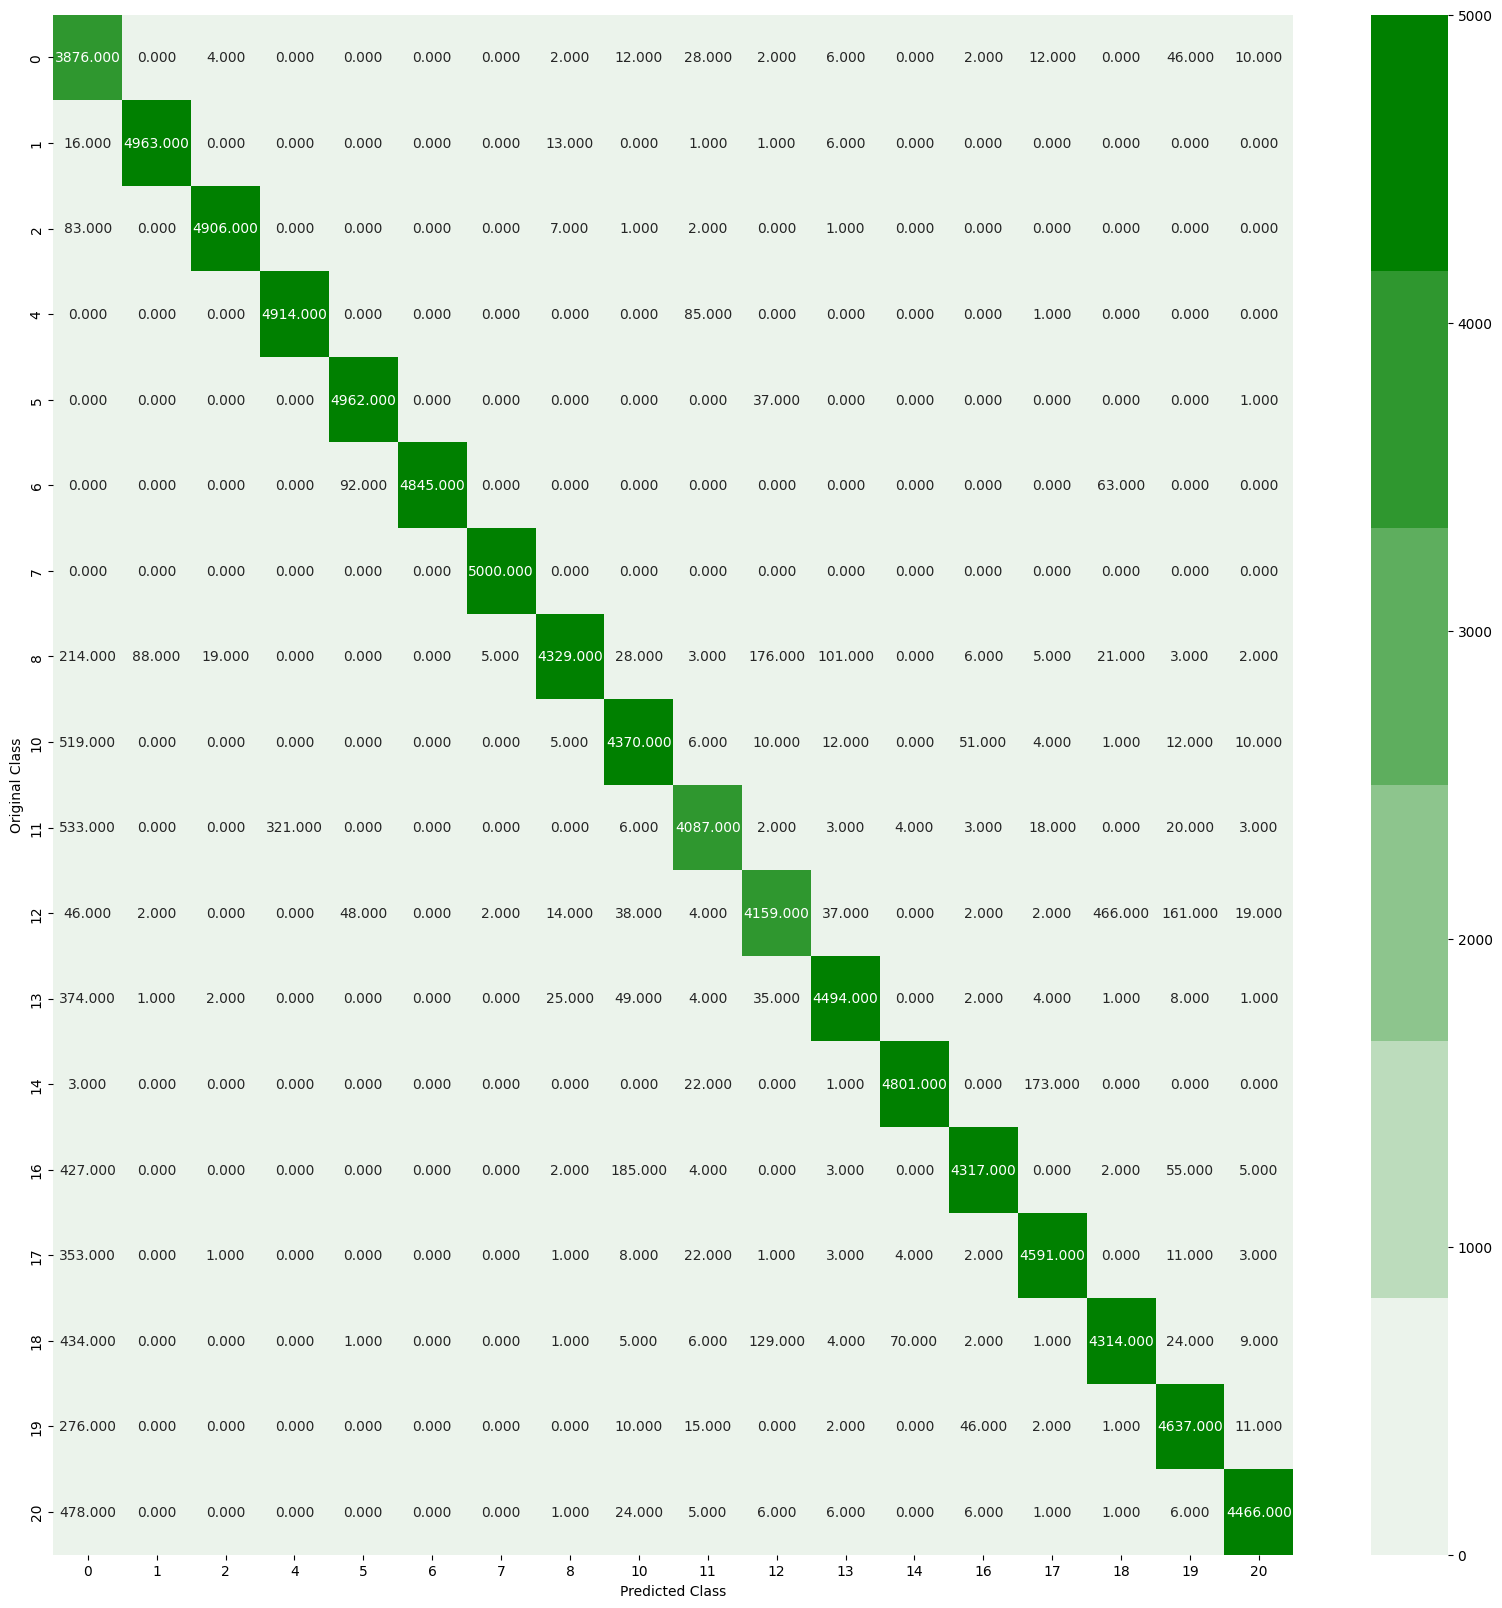

-------------------------------------------------- Precision matrix --------------------------------------------------


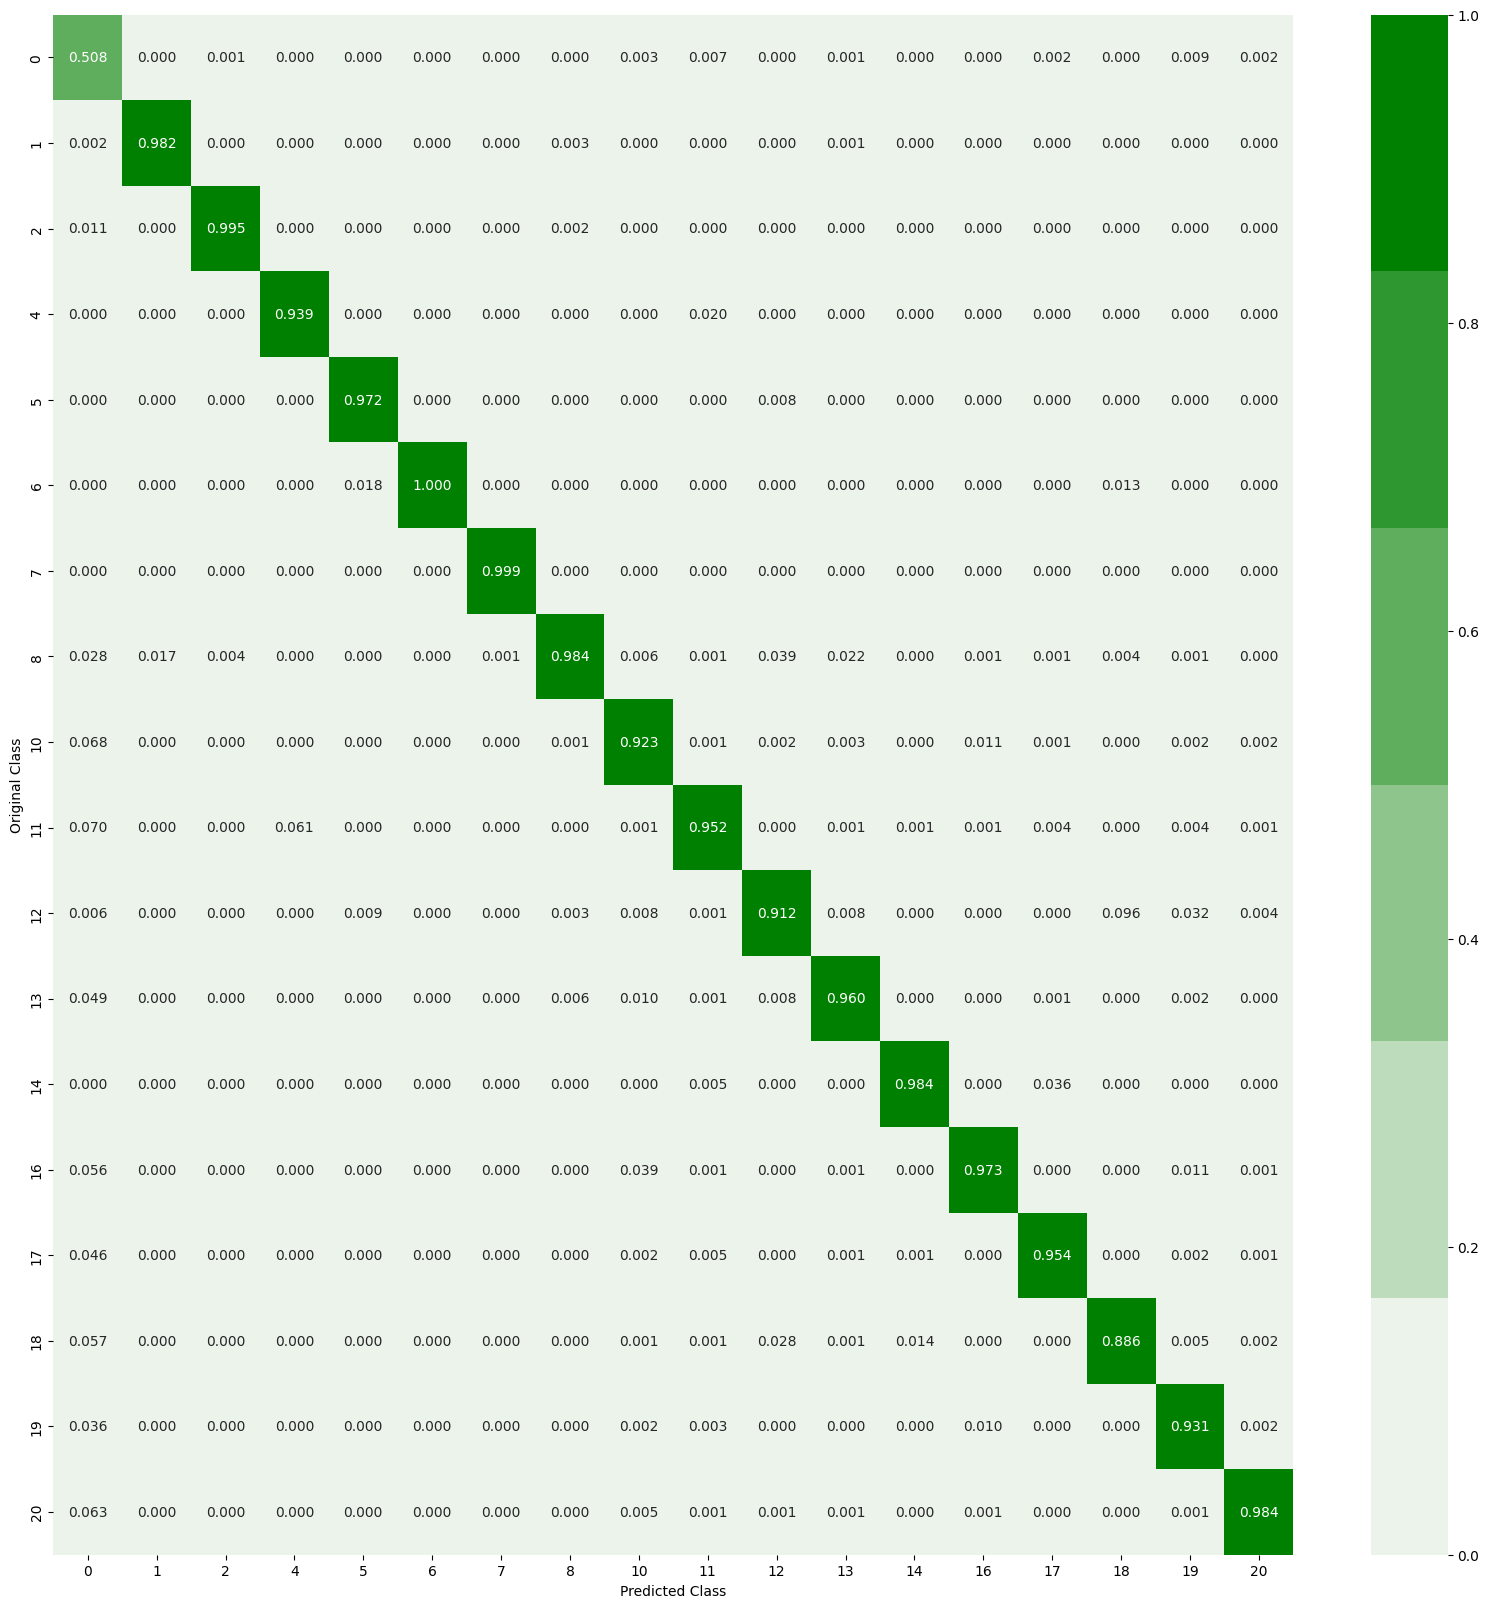

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


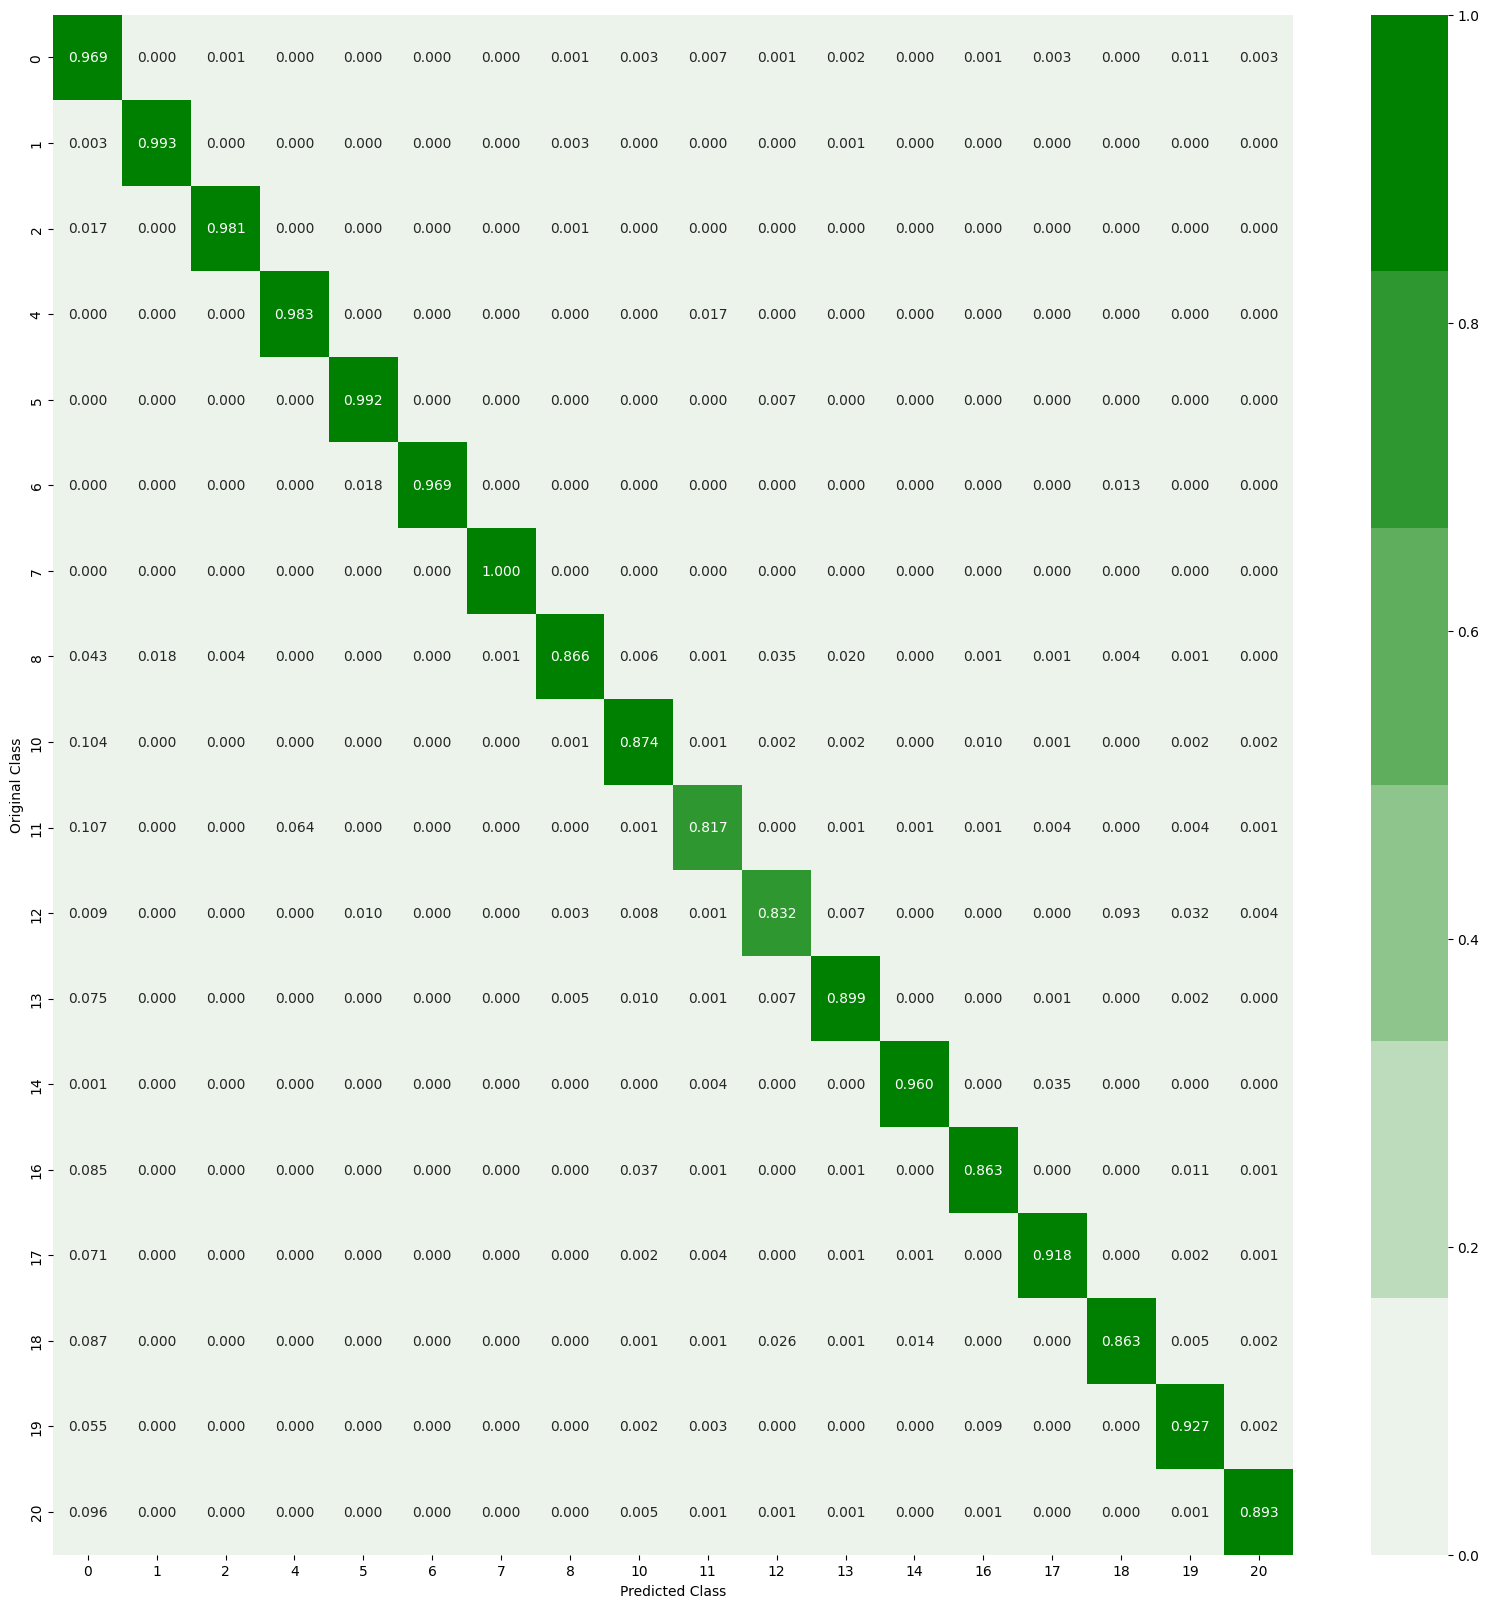

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize

# Obtener las probabilidades predichas del modelo
predict_y_prob = model.predict(test_norm)

# Convertir las probabilidades predichas en clases
predict_y_classes = np.argmax(predict_y_prob, axis=1)

predict_y_multilabel = np.argmax(predict_y_prob, axis=1)

# Convertir las clases predichas a un formato multilabel-indicator
#predict_y_multilabel = label_binarize(predict_y_classes, classes=np.unique(y_test_encoded))

# Llamar a la función plot_confusion_matrix con las etiquetas verdaderas y las predicciones
plot_confusion_matrix(np.argmax(y_test_encoded.toarray(), axis=1), predict_y_classes)


In [30]:
#dejo el codigo del batch para preguntar 
# Entrenar el modelo con los mejores hiperparámetros y un batch aleatorio en cada época
model = build_model(best_hyperparameters)
n_epochs = 10  # Número de épocas
n_steps = len(train_norm) // batch_size
for epoch in range(1, n_epochs + 1):
    accuracy = tf.keras.metrics.Accuracy(name="accuracy")  # Crear un nuevo objeto de métrica de precisión
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1):
        X_batch, y_batch = get_random_batch(train_norm, y_train_encoded.toarray(), batch_size)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch, training=True)
            loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_batch, y_pred))
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        mean_loss(loss)
        accuracy.update_state(tf.argmax(y_batch, axis=1), tf.argmax(y_pred, axis=1))  # Actualizar la métrica de accuracy
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(train_norm), mean_loss, accuracy, metrics)

Epoch 1/10


ValueError: Unknown variable: <KerasVariable shape=(52, 128), dtype=float32, path=sequential_3/dense_10/kernel>. This optimizer can only be called for the variables it was originally built with. When working with a new set of variables, you should recreate a new optimizer instance.

### Partial Dependence Plot (PDP)

['xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8', 'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18', 'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25', 'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32', 'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 'xmeas_41', 'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 'xmv_10', 'xmv_11']


In [16]:
    pdp_dist = pdp.PDPInteract(model=first_model, n_classes=18, model_features=base_features, features=base_features, df=ts, feature_names=base_features)
    im = pdp.PDPIsolate.plot(pdp_dist, base_features)
    #pdp.PDPIsolate.plot(pdp_dist, feat_name)
    print(im)

NameError: name 'pdp' is not defined

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay

NotFittedError: This Sequential instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

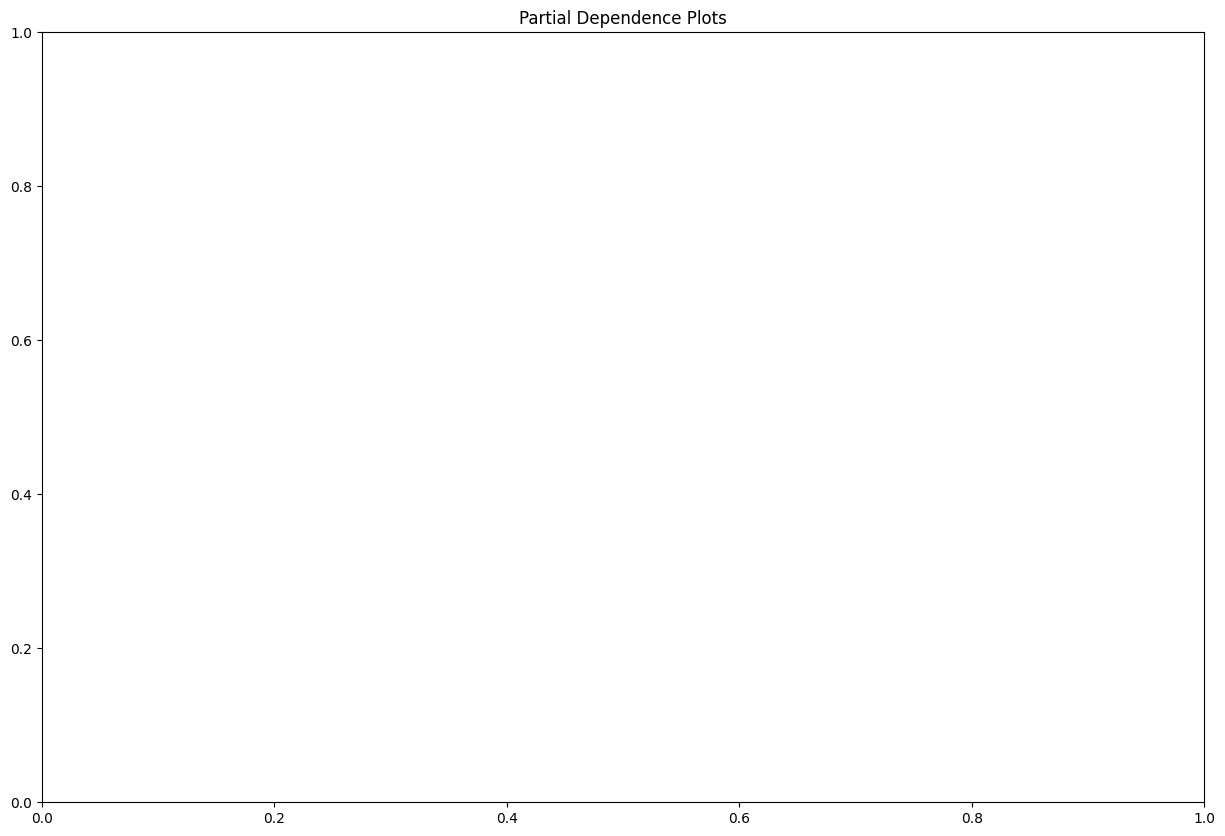

In [19]:
base_features = tr.columns.tolist()
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Partial Dependence Plots")
PartialDependenceDisplay.from_estimator(
    estimator=model,
    X=test_norm,
    features=['xmeas_2'], # the features to plot
    feature_names=base_features,
    ax=ax,    
    grid_resolution=10000
)
plt.show()

In [26]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import numpy as np
model = Sequential()

# Define tu modelo
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(52,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(18, activation='softmax')
])

# Compila el modelo
model.compile(optimizer='adamw', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrena el modelo
history = model.fit(train_norm, y_train_encoded.toarray(), epochs=10, batch_size=32, validation_data=(cv_norm, y_cv_encoded.toarray()))

# Evalúa el modelo
y_pred = model.predict(test_norm)
print("Accuracy:", accuracy)




Epoch 1/10


/home/inmamzm/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7370/7370 ━━━━━━━━━━━━━━━━━━━━ 7s 877us/step - accuracy: 0.6716 - loss: 1.1101 - val_accuracy: 0.8500 - val_loss: 0.6164
Epoch 2/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 859us/step - accuracy: 0.8620 - loss: 0.4695 - val_accuracy: 0.8883 - val_loss: 0.5329
Epoch 3/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 830us/step - accuracy: 0.9018 - loss: 0.3530 - val_accuracy: 0.9167 - val_loss: 0.4560
Epoch 4/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 876us/step - accuracy: 0.9235 - loss: 0.2892 - val_accuracy: 0.9231 - val_loss: 0.5410
Epoch 5/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 7s 1000us/step - accuracy: 0.9294 - loss: 0.2662 - val_accuracy: 0.9274 - val_loss: 0.5806
Epoch 6/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9330 - loss: 0.2530 - val_accuracy: 0.9269 - val_loss: 0.5833
Epoch 7/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 7s 904us/step - accuracy: 0.9345 - loss: 0.2459 - val_accuracy: 0.9276 - val_loss: 0.4896
Epoch 8/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 847us/step - accuracy: 0.9345 - loss: 0.242

7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 529us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 517us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 512us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 520us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 522us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 521us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 519us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 519us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 519us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 524us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 518us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 523us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 540us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 533us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 528us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 537us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 526us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 528us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 527us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 523us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 524us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 525us/step
7370/7370 

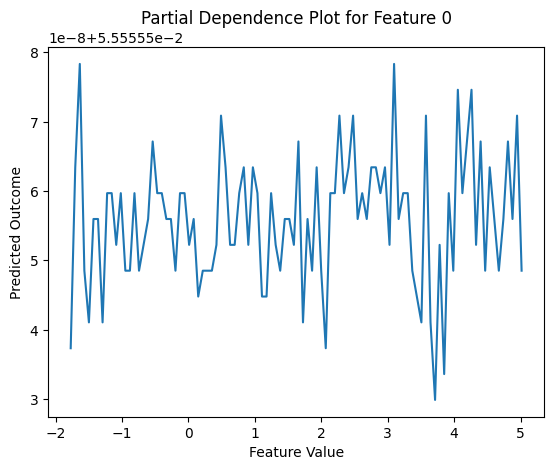

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense

# 1. Entrenar tu modelo de redes neuronales con el conjunto de datos TEP
# Supongamos que X_train y y_train son tus datos de entrenamiento y model es tu modelo entrenado

# 2. Seleccionar la característica de interés (por ejemplo, la primera característica)
feature_index = 0

# 3. Generar muestras de valores para la característica seleccionada
feature_values = np.linspace(np.min(train_norm[:, feature_index]), np.max(train_norm[:, feature_index]), 100)

# 4. Hacer predicciones condicionales para cada valor de la característica seleccionada
predictions = []
for value in feature_values:
    X_temp = train_norm.copy()
    X_temp[:, feature_index] = value
    predictions.append(np.mean(model.predict(X_temp)))  # Utiliza el promedio de las predicciones si es necesario

# 5. Visualizar los resultados
plt.plot(feature_values, predictions)
plt.xlabel('Feature Value')
plt.ylabel('Predicted Outcome')
plt.title('Partial Dependence Plot for Feature 0')
plt.show()


### ICE PLOT

In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt


# Define tu modelo
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(52,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(18, activation='softmax')
])

# Compila el modelo
model.compile(optimizer='adamw', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrena el modelo
history = model.fit(train_norm, y_train_encoded.toarray(), epochs=10, batch_size=32, validation_data=(cv_norm, y_cv_encoded.toarray()))

# Evalúa el modelo
predictions = model.predict(test_norm)
print("Accuracy:", predictions)


/home/inmamzm/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-04-22 19:59:10.671217: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-22 19:59:10.671402: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-

Epoch 1/10


I0000 00:00:1713808751.544763  342087 service.cc:145] XLA service 0x7f58d8003c20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713808751.544784  342087 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
I0000 00:00:1713808751.544786  342087 service.cc:153]   StreamExecutor device (1): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-04-22 19:59:11.560113: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-22 19:59:11.650324: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 235/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 644us/step - accuracy: 0.2285 - loss: 2.6252  

I0000 00:00:1713808752.605494  342087 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7370/7370 ━━━━━━━━━━━━━━━━━━━━ 8s 911us/step - accuracy: 0.6637 - loss: 1.1372 - val_accuracy: 0.8474 - val_loss: 0.6164
Epoch 2/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 861us/step - accuracy: 0.8650 - loss: 0.4648 - val_accuracy: 0.8925 - val_loss: 0.5165
Epoch 3/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 846us/step - accuracy: 0.9024 - loss: 0.3558 - val_accuracy: 0.9036 - val_loss: 0.5522
Epoch 4/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 877us/step - accuracy: 0.9197 - loss: 0.3019 - val_accuracy: 0.9160 - val_loss: 0.5191
Epoch 5/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 7s 882us/step - accuracy: 0.9280 - loss: 0.2756 - val_accuracy: 0.9224 - val_loss: 0.5181
Epoch 6/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 877us/step - accuracy: 0.9305 - loss: 0.2612 - val_accuracy: 0.9195 - val_loss: 0.6757
Epoch 7/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 868us/step - accuracy: 0.9326 - loss: 0.2529 - val_accuracy: 0.9266 - val_loss: 0.5241
Epoch 8/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 865us/step - accuracy: 0.9343 - loss: 0.24

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define el rango de valores para la característica de interés
feature_values = np.linspace(test_norm[41].min(), test_norm[41].max(), num=20)

# Calcula las predicciones ICE para cada valor de la característica de interés
ice_predictions = []
for value in feature_values:
    # Crea una copia de los datos de prueba
    X_ice = test_norm.copy()  
    # Reemplaza los valores de la característica de interés con el valor actual
    X_ice[41] = value  
    # Calcula las predicciones para esta instancia
    predictions = model.predict(X_ice)
    # Agrega las predicciones a la lista de predicciones ICE
    ice_predictions.append(predictions.flatten())  # Aplana las predicciones a un array 1D

# Convierte la lista de predicciones ICE en un array numpy
ice_predictions = np.array(ice_predictions)

# Visualiza el gráfico ICE
plt.figure(figsize=(10, 6))
for i in range(ice_predictions.shape[1]):
    plt.plot(feature_values, ice_predictions[:, i], color='blue', alpha=0.1)  # Una línea para cada instancia
plt.xlabel('Feature Value')
plt.ylabel('Predicted Target Variable')
plt.title('ICE Plot')
plt.show()


2782/2782 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step
2782/2782 ━━━━━━━━━━━━━━━━━━━━ 2s 544us/step
2782/2782 ━━━━━━━━━━━━━━━━━━━━ 1s 526us/step
2782/2782 ━━━━━━━━━━━━━━━━━━━━ 1s 526us/step
2782/2782 ━━━━━━━━━━━━━━━━━━━━ 1s 534us/step
2782/2782 ━━━━━━━━━━━━━━━━━━━━ 2s 542us/step
2782/2782 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step
2782/2782 ━━━━━━━━━━━━━━━━━━━━ 1s 512us/step
2782/2782 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step
2782/2782 ━━━━━━━━━━━━━━━━━━━━ 1s 510us/step
2782/2782 ━━━━━━━━━━━━━━━━━━━━ 1s 511us/step
2782/2782 ━━━━━━━━━━━━━━━━━━━━ 1s 512us/step
2782/2782 ━━━━━━━━━━━━━━━━━━━━ 1s 516us/step
2782/2782 ━━━━━━━━━━━━━━━━━━━━ 1s 509us/step
2782/2782 ━━━━━━━━━━━━━━━━━━━━ 1s 514us/step
2782/2782 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step
2782/2782 ━━━━━━━━━━━━━━━━━━━━ 1s 511us/step
2782/2782 ━━━━━━━━━━━━━━━━━━━━ 2s 555us/step
2782/2782 ━━━━━━━━━━━━━━━━━━━━ 2s 564us/step
2782/2782 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/step


KeyboardInterrupt: 

In [21]:
import numpy as np
import pycebox.ice as ice

# Verifica los valores de la característica de interés
print(test_norm[41])

# Intenta convertir los valores a un array de NumPy
feature_values = np.array(test_norm[41])

# Crea un objeto ICEBox para generar el gráfico ICE
ice_df = ice.ice(data=test_norm, column=41, predict=model.predict)

# Visualiza el gráfico ICE para cada valor de la característica de interés
for value in feature_values:
    plt.figure(figsize=(6, 4))
    ice_df.ice_plot(value, c='blue', alpha=0.1, plot_points=True)
    plt.xlabel('Feature Value')
    plt.ylabel('Predicted Target Variable')
    plt.title('ICE Plot for Feature Value: {}'.format(value))
    plt.show()


[-0.01341849  0.49732304  0.0423373   0.30280161 -0.27224694 -0.31673939
 -0.40066225 -0.45967104 -0.14085196  0.05866969  0.22549451  1.39736052
 -0.39242996  0.18797428  2.25714995 -0.39214457  0.58132582  0.07985045
 -0.07879571  0.03768562  0.24139677  0.02565878  0.19123703 -0.11154094
 -0.55013679  0.48061662 -0.05987257  0.7335436   0.03687418  0.01208262
 -0.32942336  0.17526047  0.3381419   0.46902277  0.61656877  0.98811694
  0.34740711  0.2767849  -0.23503789 -0.37877067 -0.389994   -0.51229204
 -0.26543123 -0.23156889 -0.13885332 -0.11666444  0.11125767  1.39793403
  2.25721079 -0.01328344 -0.1594195  -0.30675945]


AttributeError: 'numpy.ndarray' object has no attribute 'unique'

In [13]:
import shap
def values(): 
    x = model.p


7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 523us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 523us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 519us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 526us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 516us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 513us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 522us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 519us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 512us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 530us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 520us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 510us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 520us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 525us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 517us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 514us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 522us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 514us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 514us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 513us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 526us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 516us/step
7370/7370 

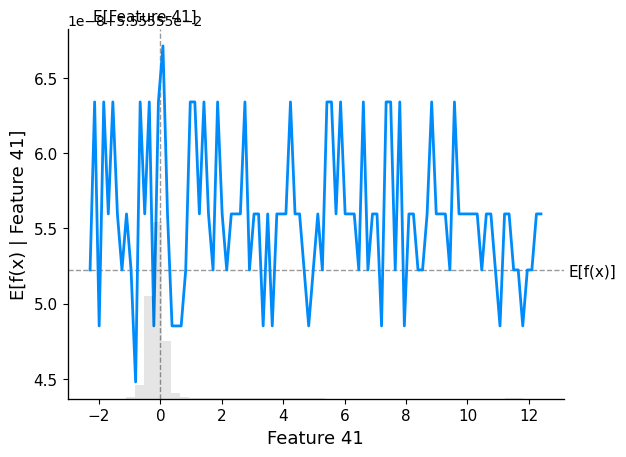

In [16]:
shap.plots.partial_dependence(
    41, lambda x: model.predict(x)[0], train_norm, ice=False,
    model_expected_value=True, feature_expected_value=True
)